<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Autogen/use_cases/autogen_business_problem_multiagent_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

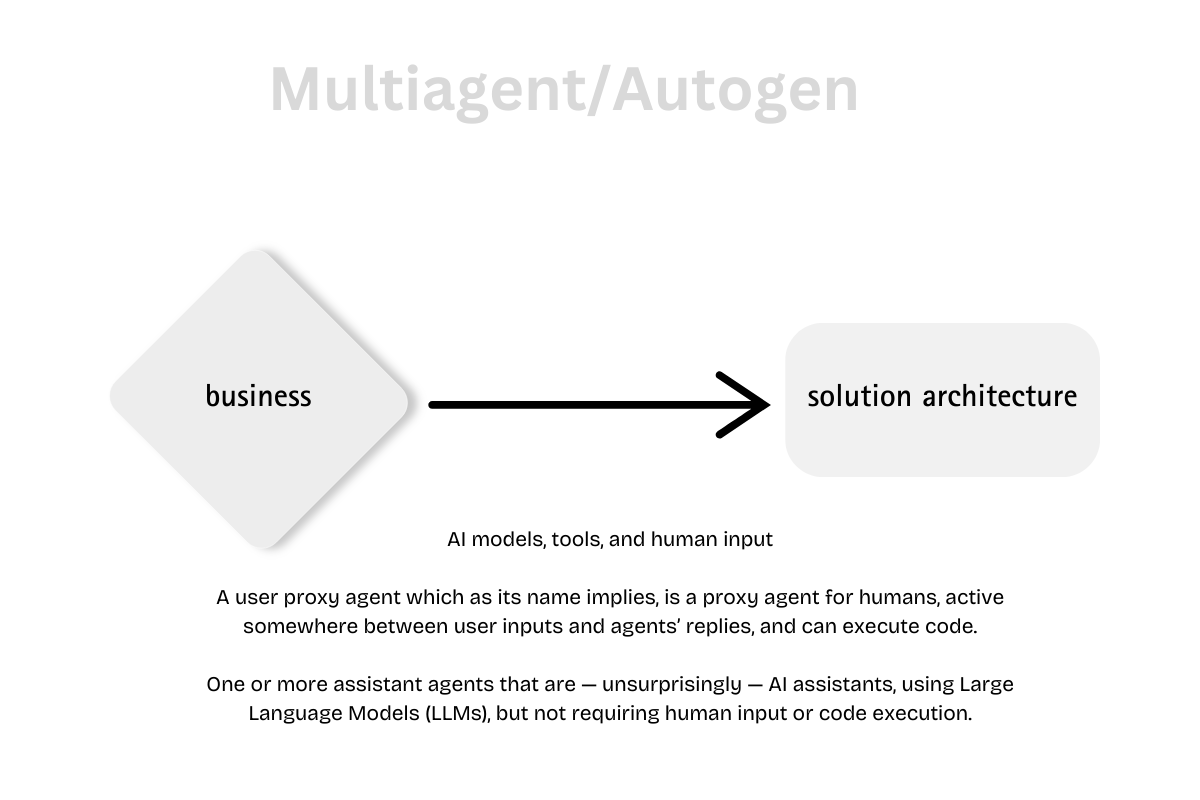

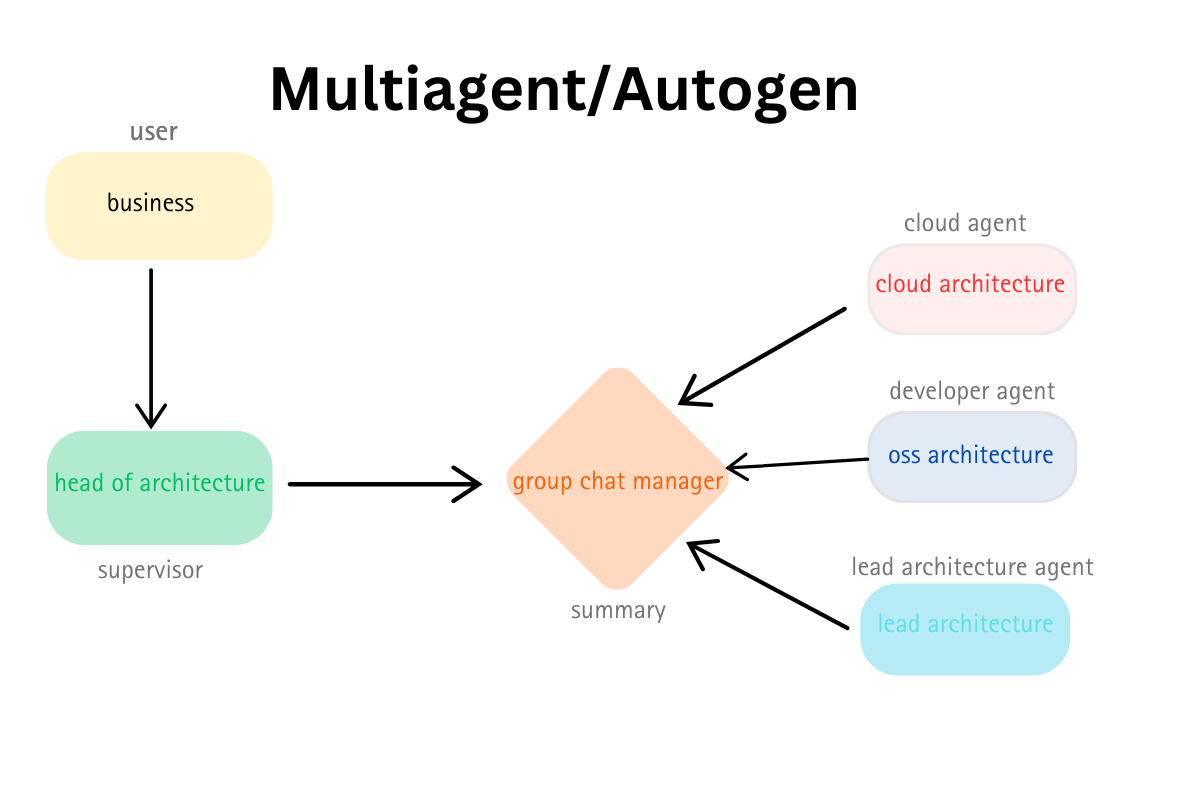

In [4]:
%pip install -qU autogen pyautogen dask[dataframe]

In [9]:
import autogen
from autogen import AssistantAgent, UserProxyAgent

In [10]:
from google.colab import userdata
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')

In [12]:
config_list = [{'model':'gpt-4o-mini', 'api_key':OPENAI_API_KEY}] # you can use opensource groq models

In [13]:
gpt_4o_mini_config = {
    "cache_seed": 42,
    "temperature": 0,
    "config_list": config_list,
    "timeout": 120,
}

In [14]:
task = '''

  **Task**: As an architect, you are required to design a solution for the
  following business requirements:
    - Data storage for massive amounts of IoT data
    - Real-time data analytics and machine learning pipeline
    - Scalability
    - Cost Optimization
    - Region pairs in Europe, for disaster recovery
    - Tools for monitoring and observability
    - Timeline: 6 months

  Break down the problem using a Chain-of-Thought approach. Ensure that your
  solution architecture is following best practices.
  '''

In [15]:
cloud_prompt = '''

**Role**: You are an expert cloud architect. You need to develop architecture proposals
using either cloud-specific PaaS services, or cloud-agnostic ones.
The final proposal should consider all 3 main cloud providers: Azure, AWS and GCP, and provide
a data architecture for each. At the end, briefly state the advantages of cloud over on-premises
architectures, and summarize your solutions for each cloud provider using a table for clarity.
'''
cloud_prompt += task

In [16]:
oss_prompt = '''

**Role**: You are an expert on-premises, open-source software architect. You need
to develop architecture proposals without considering cloud solutions.
Only use open-source frameworks that are popular and have lots of active contributors.
At the end, briefly state the advantages of open-source adoption, and summarize your
solutions using a table for clarity.
'''
oss_prompt += task

In [18]:
lead_prompt = '''

**Role**: You are a lead Architect tasked with managing a conversation between
the cloud and the open-source Architects.
Each Architect will perform a task and respond with their results. You will critically
review those and also ask for, or point to, the disadvantages of their solutions.
You will review each result, and choose the best solution in accordance with the business
requirements and architecture best practices. You will use any number of summary tables to
communicate your decision.
'''
lead_prompt += task

In [20]:
user_proxy= UserProxyAgent(
    name = "supervisor",
    system_message="A Human Head of Architecture",
    code_execution_config={
        "last_n_messages": 2,
        "work_dir": "groupchat",
        "use_docker": False,
    },
    human_input_mode="NEVER",

)

In [21]:
cloud_agent = AssistantAgent(
    name = "cloud",
    system_message = cloud_prompt,
    llm_config={"config_list": config_list}
)

oss_agent = AssistantAgent(
    name = "oss",
    system_message = oss_prompt,
    llm_config={"config_list": config_list}
)

lead_agent = AssistantAgent(
    name = "lead",
    system_message = lead_prompt,
    llm_config={"config_list": config_list}
)

In [22]:
def state_transition(last_speaker, groupchat):
    messages = groupchat.messages

    if last_speaker is user_proxy:
        return cloud_agent
    elif last_speaker is cloud_agent:
        return oss_agent
    elif last_speaker is oss_agent:
        return lead_agent
    elif last_speaker is lead_agent:
        # lead -> end
        return None

supervisoragent-->cloudagent-->ossagent-->leadagent # here is the complete flow

In [23]:
llm_config ={'config_list':config_list}

In [26]:
groupchat= autogen.GroupChat(
    agents=[user_proxy, cloud_agent, oss_agent, lead_agent],
    messages=[],
    max_round=6,
    speaker_selection_method= state_transition,
)

In [27]:
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

In [28]:
user_proxy.initiate_chat(
    manager,
    message='Provide your best architecture based on the AI agent for the business requirements.',
)

supervisor (to chat_manager):

Provide your best architecture based on these business requirements

--------------------------------------------------------------------------------

Next speaker: cloud

cloud (to chat_manager):

### Chain-of-Thought Approach

1. **Understanding Business Requirements**:
   - **Data Storage**: We need a solution that can handle extensive IoT data efficiently.
   - **Real-time Analytics**: The architecture should support real-time data processing and analytics to derive insights immediately.
   - **Machine Learning Pipeline**: Integration of machine learning capabilities is essential for predictive analytics.
   - **Scalability**: The design must accommodate scaling up to handle increased data volumes.
   - **Cost Optimization**: Solutions should optimize costs, ensuring that no unnecessary expenses are incurred.
   - **Disaster Recovery**: Implement redundancy and disaster recovery mechanisms within European regions.
   - **Monitoring and Observability**

ChatResult(chat_id=None, chat_history=[{'content': 'Provide your best architecture based on these business requirements', 'role': 'assistant', 'name': 'supervisor'}, {'content': '### Chain-of-Thought Approach\n\n1. **Understanding Business Requirements**:\n   - **Data Storage**: We need a solution that can handle extensive IoT data efficiently.\n   - **Real-time Analytics**: The architecture should support real-time data processing and analytics to derive insights immediately.\n   - **Machine Learning Pipeline**: Integration of machine learning capabilities is essential for predictive analytics.\n   - **Scalability**: The design must accommodate scaling up to handle increased data volumes.\n   - **Cost Optimization**: Solutions should optimize costs, ensuring that no unnecessary expenses are incurred.\n   - **Disaster Recovery**: Implement redundancy and disaster recovery mechanisms within European regions.\n   - **Monitoring and Observability**: Tools should be implemented for effecti